#Environment Setup

## Mount Project Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install and Import Necessary Packages

In [2]:
!pip install tensorflow-addons
import tensorflow as tf
import pandas as pd
import tensorflow.keras.preprocessing as preprocessor
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import numpy as np
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


# Utility Functions


## Retrieve Truth Indices that Map to Classes

In [3]:
def get_y_true_indices(dataset):
  truth_indices = np.concatenate([y for x, y in dataset], axis=0)
  return [np.argmax(truth_index) for truth_index in truth_indices]

##Retrieve Truth Labels from the dataset

In [4]:
def get_y_true(dataset):
  truth_indices = np.concatenate([y for x, y in dataset], axis=0)
  return [dataset.class_names[np.argmax(truth_index)] for truth_index in truth_indices]

## Create a Class Name(n000001) to Person Name(Dalai Lama) Mapping

In [5]:
def get_mapping():
  identity_map = pd.read_csv("/content/drive/Shareddrives/CS6220_FinalProject/meta/identity_meta_fixed.csv")
  t = tuple(zip(identity_map.Name, identity_map.Gender))
  mapping = dict(zip(identity_map.Class_ID, t))
  return mapping

## Convert the Truth/Predicted Labels to Real Names

In [6]:
def class_to_name(labels, mapping):
  return [mapping[i][0] for i in labels]

## Retrieve Predicted Labels

In [29]:
def get_y_pred(predictions):
  return [np.argmax(p) for p in predictions]

## Retireve Predicted Classes(n000xxxx)

In [8]:
def get_pred_classes(y_pred, dataset):
  return [dataset.class_names[i] for i in y_pred]

## Create a Confusion Matrix Based on Truth and Predictions

In [9]:
def create_confusion_matrix(truth, preds, num_classes):
  c_mat = tf.math.confusion_matrix(labels=truth, predictions=preds, num_classes=num_classes)
  return c_mat

## Draw Confusion Matrix

In [10]:
def plot_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

# Transfer Learning with Imagenet Weights

## Feature Extraction

### GPU Configuration


In [11]:
%cd /content/drive/Shareddrives/CS6220_FinalProject/tensorflow_experiment_folder

/content/drive/Shareddrives/CS6220_FinalProject/tensorflow_experiment_folder


In [12]:
#check gpu availability
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
tf.config.list_physical_devices('GPU') #confirm that TensorFlow is using the GPU

Name: /physical_device:GPU:0   Type: GPU


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Data Preprocessing

In [13]:
#preprocess the training data
train_data_dir = "./train_high_cloaked_cropped"#CHANGE this if you want to train another dataset
#use 80% for training and 20% for evaluation
#only use label_mode="categorical" because we want to compute the f1 score
train_dataset = preprocessor.image_dataset_from_directory(train_data_dir, 
                                                          image_size=(224,224), validation_split=0.2, label_mode="categorical", subset="training", seed=42)
eval_dataset = preprocessor.image_dataset_from_directory(train_data_dir, image_size=(224,224), label_mode="categorical",
                                                          validation_split=0.2, subset="validation", seed=42)
#clean the class names to let them only contains n0000xxxx
if '_' in train_dataset.class_names[0]:
  train_dataset.class_names = [class_name.split('_')[0] for class_name in train_dataset.class_names]
  eval_dataset.class_names = [class_name.split('_')[0] for class_name in eval_dataset.class_names]
print(train_dataset.class_names)
print(eval_dataset.class_names)

Found 7188 files belonging to 40 classes.
Using 5751 files for training.
Found 7188 files belonging to 40 classes.
Using 1437 files for validation.
['n000001', 'n000029', 'n000078', 'n000082', 'n000106', 'n000129', 'n000148', 'n000149', 'n000178', 'n000259', 'n000284', 'n000363', 'n000394', 'n000452', 'n000480', 'n000527', 'n000596', 'n000624', 'n000654', 'n000658', 'n000659', 'n000667', 'n000689', 'n000706', 'n000736', 'n000740', 'n000746', 'n000774', 'n000775', 'n000785', 'n000838', 'n000854', 'n000912', 'n000928', 'n000945', 'n000950', 'n000958', 'n000998', 'n001021', 'n001059']
['n000001', 'n000029', 'n000078', 'n000082', 'n000106', 'n000129', 'n000148', 'n000149', 'n000178', 'n000259', 'n000284', 'n000363', 'n000394', 'n000452', 'n000480', 'n000527', 'n000596', 'n000624', 'n000654', 'n000658', 'n000659', 'n000667', 'n000689', 'n000706', 'n000736', 'n000740', 'n000746', 'n000774', 'n000775', 'n000785', 'n000838', 'n000854', 'n000912', 'n000928', 'n000945', 'n000950', 'n000958', 'n0

In [14]:
print(len(train_dataset.class_names))
print(len(eval_dataset.class_names))

40
40


In [15]:
input_shape = None
count = 0
for image_batch, labels_batch in train_dataset:
  input_shape = image_batch.shape
  print(image_batch.shape)
  print(labels_batch)
  count += 1
  if count == 3: break
  #break

(32, 224, 224, 3)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 40), dtype=float32)
(32, 224, 224, 3)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 40), dtype=float32)
(32, 224, 224, 3)
tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(32, 40), dtype=float32)


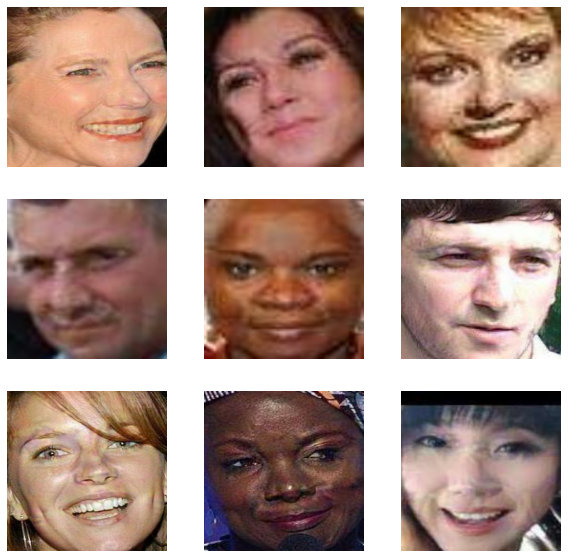

In [16]:
#visualize the preprocessed data batch
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    #plt.title(class_names[labels[i]])
    plt.axis("off")

### Model Training And Evaluation without Data Augmentation

In [17]:
#create a mobilenet_v3 classifier with imagenet weights
print(input_shape)
#set include_top to false for transfer learning
base_model = tf.keras.applications.MobileNetV3Large(input_shape = (224,224,3), weights="imagenet", include_top=False)
base_model.summary()


(32, 224, 224, 3)
17620992/17605208 [==============================] - 0s 0us/step
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 


In [18]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1, 1, 1280)


In [19]:
# #Add a data augmentation layer
# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

In [20]:
# #display how data augmentation looks like
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [21]:
#freeze the base model
base_model.trainable = False

In [22]:
#create a new model on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
# We make sure to let the base model run in inferrence mode,
# by passing `training=False`. This is important for fine-tuning
#x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#create a dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# A Dense classifier with a number of classes as the train dataset has
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 40)                51240     
                                                                 
Total params: 4,277,672
Trainable params: 51,240
Non-trainabl

In [23]:
#compile the model
#accuracy = tf.keras.metrics.CategoricalAccuracy()
f1 = tfa.metrics.F1Score(num_classes=len(class_names),average='weighted')
model.compile(optimizer='rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy", f1])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 40)                51240     
                                                                 
Total params: 4,277,672
Trainable params: 51,240
Non-trainabl

In [24]:
#initialize starting loss
loss0, accuracy0, f1score_0 = model.evaluate(eval_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1_score: {:.2f}".format(f1score_0))

45/45 [==============================] - 224s 4s/step - loss: 3.9804 - accuracy: 0.0341 - f1_score: 0.0162
initial loss: 3.98
initial accuracy: 0.03
initial f1_score: 0.02


In [25]:
#train the model
tf.debugging.set_log_device_placement(True)
train_result = model.fit(x=train_dataset, validation_data=eval_dataset, epochs=10)


Epoch 1/10
180/180 [==============================] - 855s 5s/step - loss: 2.4508 - accuracy: 0.3455 - f1_score: 0.3392 - val_loss: 1.8230 - val_accuracy: 0.5038 - val_f1_score: 0.4925
Epoch 2/10
180/180 [==============================] - 22s 118ms/step - loss: 1.5453 - accuracy: 0.5747 - f1_score: 0.5685 - val_loss: 1.4865 - val_accuracy: 0.5950 - val_f1_score: 0.5948
Epoch 3/10
180/180 [==============================] - 22s 117ms/step - loss: 1.2421 - accuracy: 0.6486 - f1_score: 0.6446 - val_loss: 1.3313 - val_accuracy: 0.6277 - val_f1_score: 0.6276
Epoch 4/10
180/180 [==============================] - 22s 117ms/step - loss: 1.0763 - accuracy: 0.7037 - f1_score: 0.7015 - val_loss: 1.2213 - val_accuracy: 0.6562 - val_f1_score: 0.6528
Epoch 5/10
180/180 [==============================] - 21s 116ms/step - loss: 0.9572 - accuracy: 0.7336 - f1_score: 0.7318 - val_loss: 1.1690 - val_accuracy: 0.6708 - val_f1_score: 0.6718
Epoch 6/10
180/180 [==============================] - 21s 117ms/ste

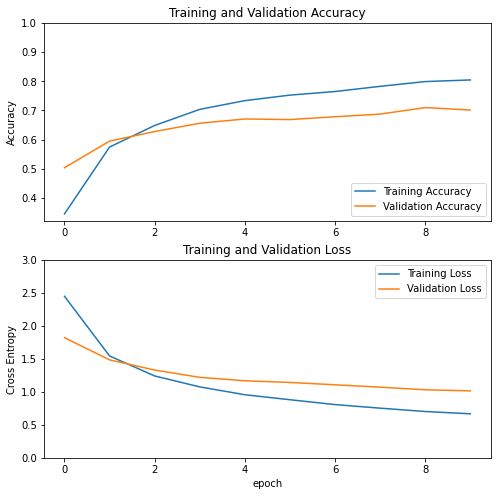

In [26]:
#check the learning curves
acc = train_result.history['accuracy']
val_acc = train_result.history['val_accuracy']

loss = train_result.history['loss']
val_loss = train_result.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluate the Model Prediction Accuracy After Feature Extraction

In [ ]:
#load the test dataset
test_data_dir = "/content/drive/Shareddrives/CS6220_FinalProject/tensorflow_experiment_folder/test_original_unseen_cropped" #CHANGE if you want to test on different datasets
test_dataset = preprocessor.image_dataset_from_directory(test_data_dir, label_mode="categorical", image_size=(224,224))
#clean the class names to let them only contains n0000xxxx
if '_' in test_dataset.class_names[0]:
  test_dataset.class_names = [class_name.split('_')[0] for class_name in train_dataset.class_names]
print(test_dataset.class_names)
model.evaluate(test_dataset)

#### Display a Confusion Matrix

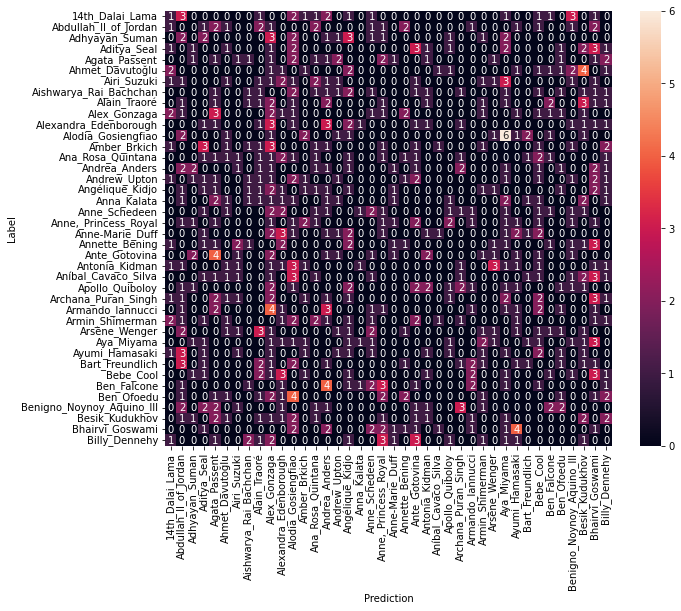

In [30]:
#class-name mapping
mapping = get_mapping()
#get unprocessed raw prediction results
preds_raw = model.predict(x=test_dataset)
#the array that contains the indices corresponding to the classes
y_pred_indices = get_y_pred(preds_raw)
#the classes reduced from indices
y_pred_classes = get_pred_classes(y_pred_indices, test_dataset)
#print(y_pred_classes)
#print(preds_raw)
#print(get_y_true_indices(test_dataset))
#map the predicted classes to real names
y_pred_names = class_to_name(y_pred_classes, mapping)
#print(y_pred_names)
#true labels
#print(get_y_true_indices(test_dataset)[0])
y_true = get_y_true(test_dataset)
#print(y_true)
#print(len(y_true))
true_names = class_to_name(y_true, mapping)
#print(true_names)
#confusion matrix
y_true_indices = get_y_true_indices(test_dataset)
c_mat = create_confusion_matrix(y_true_indices, y_pred_indices, len(test_dataset.class_names))
#convert class names to person names
person_names = class_to_name(test_dataset.class_names, mapping)
#draw confusion matrix
plot_confusion_matrix(c_mat, person_names)

### Model Training and Evaluation with Data Augmentation (Skip If You Want to Experiment without Data Augmentation)

In [ ]:
#create a mobilenet_v3 classifier with imagenet weights
print(input_shape)
#set include_top to false for transfer learning
base_model = tf.keras.applications.MobileNetV3Large(input_shape = (224,224,3), weights="imagenet", include_top=False)
base_model.summary()

In [32]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1, 1, 1280)


In [33]:
#Add a data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

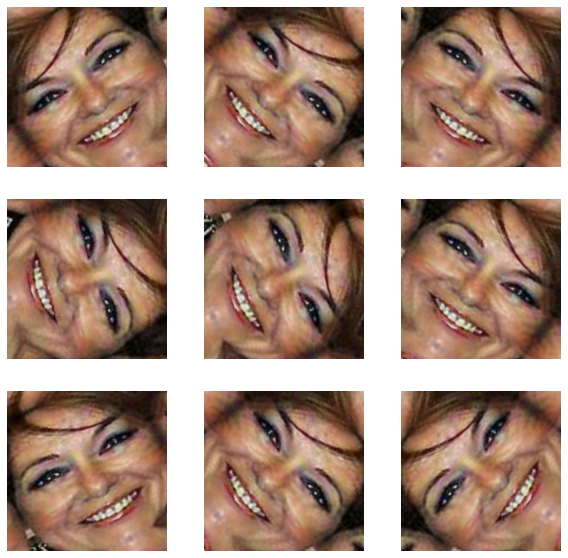

In [34]:
#display how data augmentation looks like
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [35]:
#freeze the base model
base_model.trainable = False

In [36]:
#create a new model on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
# We make sure to let the base model run in inferrence mode,
# by passing `training=False`. This is important for fine-tuning
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#create a dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# A Dense classifier with a number of classes as the train dataset has
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 40)                5124

In [39]:
#compile the model
#accuracy = tf.keras.metrics.CategoricalAccuracy()
f1 = tfa.metrics.F1Score(num_classes=len(class_names),average='weighted')
model.compile(optimizer='rmsprop', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=["accuracy", f1])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 40)                5124

In [40]:
#initialize starting loss
loss0, accuracy0, f1score_0 = model.evaluate(eval_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1_score: {:.2f}".format(f1score_0))

45/45 [==============================] - 7s 94ms/step - loss: 3.9916 - accuracy: 0.0216 - f1_score: 0.0092
initial loss: 3.99
initial accuracy: 0.02
initial f1_score: 0.01


In [41]:
#train the model
tf.debugging.set_log_device_placement(True)
train_result = model.fit(x=train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
180/180 [==============================] - 27s 117ms/step - loss: 2.8275 - accuracy: 0.2481 - f1_score: 0.2416 - val_loss: 2.3519 - val_accuracy: 0.3793 - val_f1_score: 0.3523
Epoch 2/10
180/180 [==============================] - 22s 118ms/step - loss: 1.9959 - accuracy: 0.4488 - f1_score: 0.4408 - val_loss: 1.9892 - val_accuracy: 0.4405 - val_f1_score: 0.4294
Epoch 3/10
180/180 [==============================] - 22s 118ms/step - loss: 1.7248 - accuracy: 0.5218 - f1_score: 0.5168 - val_loss: 1.7883 - val_accuracy: 0.5010 - val_f1_score: 0.4933
Epoch 4/10
180/180 [==============================] - 22s 119ms/step - loss: 1.5705 - accuracy: 0.5542 - f1_score: 0.5490 - val_loss: 1.6863 - val_accuracy: 0.5310 - val_f1_score: 0.5254
Epoch 5/10
180/180 [==============================] - 22s 120ms/step - loss: 1.4609 - accuracy: 0.5872 - f1_score: 0.5834 - val_loss: 1.5933 - val_accuracy: 0.5505 - val_f1_score: 0.5470
Epoch 6/10
180/180 [==============================] - 22s 118ms/s

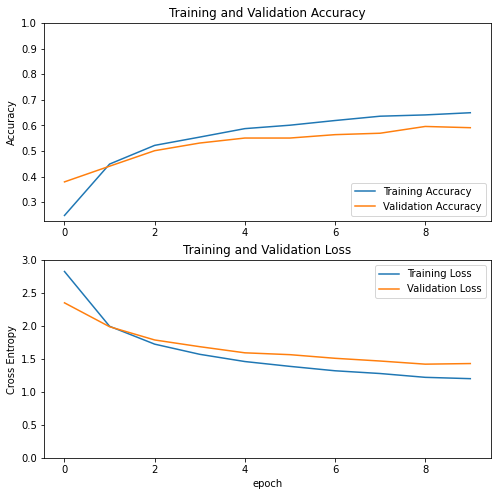

In [42]:
#check the learning curves
acc = train_result.history['accuracy']
val_acc = train_result.history['val_accuracy']

loss = train_result.history['loss']
val_loss = train_result.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

####Evaluate the Model Prediction Accuracy After Feature Extraction


In [44]:
#load the test dataset
test_data_dir = "/content/drive/Shareddrives/CS6220_FinalProject/tensorflow_experiment_folder/test_original_unseen_cropped" #CHANGE if you want to test on different datasets
test_dataset = preprocessor.image_dataset_from_directory(test_data_dir, label_mode="categorical", image_size=(224,224))
#clean the class names to let them only contains n0000xxxx
if '_' in test_dataset.class_names[0]:
  test_dataset.class_names = [class_name.split('_')[0] for class_name in train_dataset.class_names]
print(test_dataset.class_names)
model.evaluate(test_dataset)

Found 798 files belonging to 40 classes.
['n000001', 'n000029', 'n000078', 'n000082', 'n000106', 'n000129', 'n000148', 'n000149', 'n000178', 'n000259', 'n000284', 'n000363', 'n000394', 'n000452', 'n000480', 'n000527', 'n000596', 'n000624', 'n000654', 'n000658', 'n000659', 'n000667', 'n000689', 'n000706', 'n000736', 'n000740', 'n000746', 'n000774', 'n000775', 'n000785', 'n000838', 'n000854', 'n000912', 'n000928', 'n000945', 'n000950', 'n000958', 'n000998', 'n001021', 'n001059']
25/25 [==============================] - 3s 98ms/step - loss: 2.2019 - accuracy: 0.4185 - f1_score: 0.4035


[2.20188570022583, 0.4185463786125183, 0.403522253036499]

#### Display a Confusion Matrix

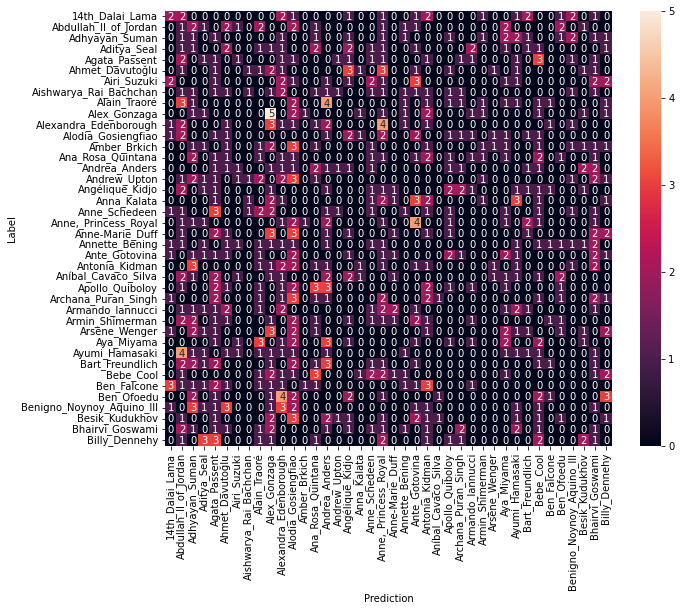

In [47]:
#class-name mapping
mapping = get_mapping()
#get unprocessed raw prediction results
preds_raw = model.predict(x=test_dataset)

#the array that contains the indices corresponding to the classes
y_pred_indices = get_y_pred(preds_raw)
#the classes reduced from indices
y_pred_classes = get_pred_classes(y_pred_indices, test_dataset)
#map the predicted classes to real names
y_pred_names = class_to_name(y_pred_classes, mapping)
#print(y_pred_names)
#true labels
y_true = get_y_true(test_dataset)
#print(len(y_true))
true_names = class_to_name(y_true, mapping)
#print(true_names)
#confusion matrix
y_true_indices = get_y_true_indices(test_dataset)
c_mat = create_confusion_matrix(y_true_indices, y_pred_indices, len(test_dataset.class_names))
#convert class names to person names
person_names = class_to_name(test_dataset.class_names, mapping)
#draw confusion matrix
plot_confusion_matrix(c_mat, person_names)
# # acc = 0
# # for i in range(0, len(y_true_indices)):
# #   if y_true_indices[i] == y_pred_indices[i]:
# #     acc += 1
# # print(acc / len(y_pred_indices))

## Fine Tune the Feature Extracted Model (Optional step, because our training dataset is small in size. Easy to Cause Overfitting)




### Unfreeze and Fine Tune Front Layers

In [48]:
#unfreeze the base model
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  269


In [49]:
# Fine-tune from this layer onwards
fine_tune_at = 230

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

### Model Retraining

In [51]:
#recompile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), 
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 40)                5124

23

In [52]:
#continue training the model
initial_epochs = 10
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=train_result.epoch[-1],
                         validation_data=eval_dataset)

Epoch 10/20
180/180 [==============================] - 32s 138ms/step - loss: 1.0277 - accuracy: 0.6947 - val_loss: 1.0288 - val_accuracy: 0.6896
Epoch 11/20
180/180 [==============================] - 24s 130ms/step - loss: 0.8317 - accuracy: 0.7534 - val_loss: 1.0052 - val_accuracy: 0.7063
Epoch 12/20
180/180 [==============================] - 24s 131ms/step - loss: 0.7257 - accuracy: 0.7766 - val_loss: 0.9096 - val_accuracy: 0.7390
Epoch 13/20
180/180 [==============================] - 24s 131ms/step - loss: 0.6187 - accuracy: 0.8141 - val_loss: 0.8614 - val_accuracy: 0.7488
Epoch 14/20
180/180 [==============================] - 24s 130ms/step - loss: 0.5713 - accuracy: 0.8254 - val_loss: 0.7770 - val_accuracy: 0.7704
Epoch 15/20
180/180 [==============================] - 24s 130ms/step - loss: 0.4990 - accuracy: 0.8445 - val_loss: 0.8337 - val_accuracy: 0.7648
Epoch 16/20
180/180 [==============================] - 24s 131ms/step - loss: 0.4284 - accuracy: 0.8628 - val_loss: 0.7339 -

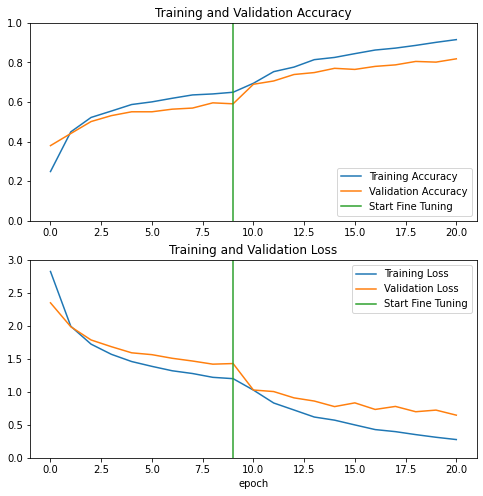

In [53]:
#plot out the fine-tuning learning curves
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluate Prediction Accuracy After Fine-tuning

In [ ]:
test_data_dir = "./test_original_unseen_cropped" #CHANGE if you want to test on different datasets
test_dataset = preprocessor.image_dataset_from_directory(test_data_dir, image_size=(224,224))
#clean the class names to let them only contains n0000xxxx
if '_' in test_dataset.class_names[0]:
  test_dataset.class_names = [class_name.split('_')[0] for class_name in train_dataset.class_names]
print(test_dataset.class_names)
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)
print("Test loss: ", loss)

Found 798 files belonging to 40 classes.
['n000001', 'n000029', 'n000078', 'n000082', 'n000106', 'n000129', 'n000148', 'n000149', 'n000178', 'n000259', 'n000284', 'n000363', 'n000394', 'n000452', 'n000480', 'n000527', 'n000596', 'n000624', 'n000654', 'n000658', 'n000659', 'n000667', 'n000689', 'n000706', 'n000736', 'n000740', 'n000746', 'n000774', 'n000775', 'n000785', 'n000838', 'n000854', 'n000912', 'n000928', 'n000945', 'n000950', 'n000958', 'n000998', 'n001021', 'n001059']
25/25 [==============================] - 3s 95ms/step - loss: 1.6491 - accuracy: 0.6704
Test accuracy : 0.670426070690155
Test loss:  1.649146318435669


# Train Mobilenet from Randomly Initalized Weights


In [ ]:
%cd /content/drive/Shareddrives/CS6220_FinalProject/tensorflow_experiment_folder

/content/drive/Shareddrives/CS6220_FinalProject/tensorflow_experiment_folder


## GPU Configuration


In [ ]:
#check gpu availability
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
tf.config.list_physical_devices('GPU') #confirm that TensorFlow is using the GPU

Name: /physical_device:GPU:0   Type: GPU


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Preprocessing

In [ ]:
#preprocess the training data
train_data_dir = "./train_low_cloaked_cropped"#CHANGE this if you want to train another dataset
#use 80% for training and 20% for evaluation
train_dataset = preprocessor.image_dataset_from_directory(train_data_dir, image_size=(224,224),  validation_split=0.2, subset="training", seed=42)
eval_dataset = preprocessor.image_dataset_from_directory(train_data_dir, image_size=(224,224), validation_split=0.2, subset="validation", seed=42)
#clean the class names to let them only contains n0000xxxx
if '_' in train_dataset.class_names[0]:
  train_dataset.class_names = [class_name.split('_')[0] for class_name in train_dataset.class_names]
  eval_dataset.class_names = [class_name.split('_')[0] for class_name in eval_dataset.class_names]
print(train_dataset.class_names)
print(eval_dataset.class_names)

Found 7188 files belonging to 40 classes.
Using 5751 files for training.
Found 7188 files belonging to 40 classes.
Using 1437 files for validation.
['n000001', 'n000029', 'n000078', 'n000082', 'n000106', 'n000129', 'n000148', 'n000149', 'n000178', 'n000259', 'n000284', 'n000363', 'n000394', 'n000452', 'n000480', 'n000527', 'n000596', 'n000624', 'n000654', 'n000658', 'n000659', 'n000667', 'n000689', 'n000706', 'n000736', 'n000740', 'n000746', 'n000774', 'n000775', 'n000785', 'n000838', 'n000854', 'n000912', 'n000928', 'n000945', 'n000950', 'n000958', 'n000998', 'n001021', 'n001059']
['n000001', 'n000029', 'n000078', 'n000082', 'n000106', 'n000129', 'n000148', 'n000149', 'n000178', 'n000259', 'n000284', 'n000363', 'n000394', 'n000452', 'n000480', 'n000527', 'n000596', 'n000624', 'n000654', 'n000658', 'n000659', 'n000667', 'n000689', 'n000706', 'n000736', 'n000740', 'n000746', 'n000774', 'n000775', 'n000785', 'n000838', 'n000854', 'n000912', 'n000928', 'n000945', 'n000950', 'n000958', 'n0

In [ ]:
print(len(train_dataset.class_names))
print(len(eval_dataset.class_names))

40
40


In [ ]:
input_shape = None
count = 0
for image_batch, labels_batch in train_dataset:
  input_shape = image_batch.shape
  print(image_batch.shape)
  print(labels_batch)
  count += 1
  if count == 3: break
  #break

(32, 224, 224, 3)
tf.Tensor(
[19 21 26 21 27 12 14 18  8 28 18 22 38 14 34  8 20 34  5 37 12 16 14  1
 21  5 36 14 29 39  9 26], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor(
[ 4 34  2 28 21 16 12 20  7 11  2 21  8 34 34 30  4  0  1  5 32 22 17  0
 23 14 32 34 13 31  2  9], shape=(32,), dtype=int32)
(32, 224, 224, 3)
tf.Tensor(
[18  4 11 28 39 26 26 36 12  1  5 33 17 38  1 24 20 21  1 32 21 16 36  7
 25 35 18 21 11  0 28  5], shape=(32,), dtype=int32)


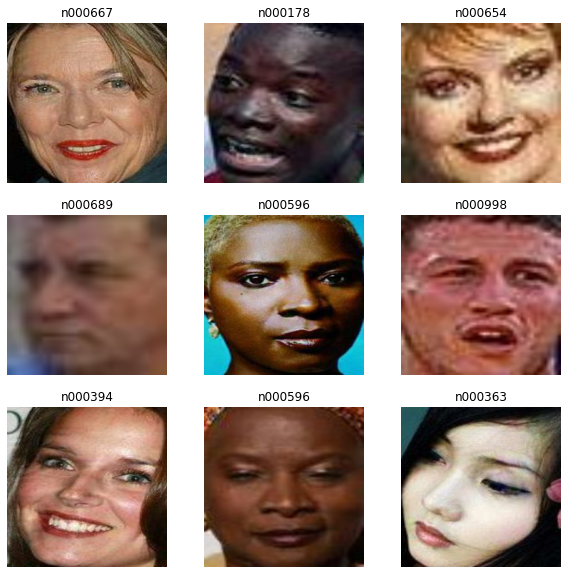

In [ ]:
#visualize the preprocessed data batch
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model Training and Evaluation Without Data Augmentation

In [ ]:
#create a mobilenet_v3 classifier with randomly initialized weights
print(input_shape)
#set include_top to false for transfer learning
base_model = tf.keras.applications.MobileNetV3Large(input_shape = (224,224,3), weights=None, include_top=False)
base_model.summary()

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1, 1, 1280)


In [ ]:
#create a new model on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
#We have to train all layers
#x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=True)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#create a dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# A Dense classifier with a number of classes as the train dataset has
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 40)                51240 

In [ ]:
#compile the model
#import tensorflow_addons as tfa
#f1 = tfa.metrics.F1Score(num_classes=len(class_names),average='macro')
model.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 1, 1, 1280)       4226432   
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 40)                51240 

In [ ]:
#initialize starting loss
loss0, accuracy0= model.evaluate(eval_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
#print("initial f1_score: {:.2f}".format(f1_score0))

45/45 [==============================] - 179s 3s/step - loss: 3.7187 - accuracy: 0.0230
initial loss: 3.72
initial accuracy: 0.02


In [ ]:
#train the model
tf.debugging.set_log_device_placement(True)
train_result = model.fit(x=train_dataset, validation_data=eval_dataset, epochs=12)

Epoch 1/12
180/180 [==============================] - 667s 4s/step - loss: 3.4493 - accuracy: 0.0929 - val_loss: 3.0759 - val_accuracy: 0.1364
Epoch 2/12
180/180 [==============================] - 94s 520ms/step - loss: 2.7135 - accuracy: 0.2160 - val_loss: 2.2727 - val_accuracy: 0.2888
Epoch 3/12
180/180 [==============================] - 94s 519ms/step - loss: 2.2308 - accuracy: 0.3399 - val_loss: 1.9029 - val_accuracy: 0.4078
Epoch 4/12
180/180 [==============================] - 94s 518ms/step - loss: 1.8143 - accuracy: 0.4387 - val_loss: 1.7011 - val_accuracy: 0.4753
Epoch 5/12
180/180 [==============================] - 94s 518ms/step - loss: 1.5373 - accuracy: 0.5274 - val_loss: 1.4455 - val_accuracy: 0.5609
Epoch 6/12
180/180 [==============================] - 94s 520ms/step - loss: 1.3760 - accuracy: 0.5782 - val_loss: 1.2638 - val_accuracy: 0.6089
Epoch 7/12
180/180 [==============================] - 94s 518ms/step - loss: 1.1994 - accuracy: 0.6328 - val_loss: 1.1567 - val_accu

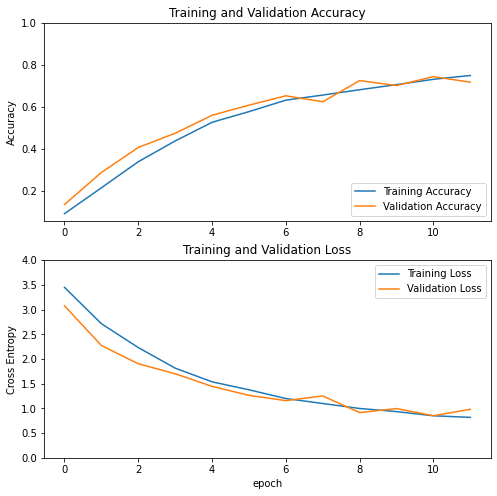

In [ ]:
#check the learning curves
acc = train_result.history['accuracy']
val_acc = train_result.history['val_accuracy']

loss = train_result.history['loss']
val_loss = train_result.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Evaluate the Model Prediction Accuracy





In [ ]:
#load the test dataset
test_data_dir = "/content/drive/Shareddrives/CS6220_FinalProject/tensorflow_experiment_folder/test_original_unseen_cropped" #CHANGE if you want to test on different datasets
test_dataset = preprocessor.image_dataset_from_directory(test_data_dir, image_size=(224,224))
#clean the class names to let them only contains n0000xxxx
if '_' in test_dataset.class_names[0]:
  test_dataset.class_names = [class_name.split('_')[0] for class_name in train_dataset.class_names]
print(test_dataset.class_names)
model.evaluate(test_dataset)


Found 798 files belonging to 40 classes.
['n000001', 'n000029', 'n000078', 'n000082', 'n000106', 'n000129', 'n000148', 'n000149', 'n000178', 'n000259', 'n000284', 'n000363', 'n000394', 'n000452', 'n000480', 'n000527', 'n000596', 'n000624', 'n000654', 'n000658', 'n000659', 'n000667', 'n000689', 'n000706', 'n000736', 'n000740', 'n000746', 'n000774', 'n000775', 'n000785', 'n000838', 'n000854', 'n000912', 'n000928', 'n000945', 'n000950', 'n000958', 'n000998', 'n001021', 'n001059']
25/25 [==============================] - 96s 2s/step - loss: 2.1524 - accuracy: 0.5163


[2.15244460105896, 0.5162907242774963]

### Display a Confusion Matrix

In [ ]:
#class-name mapping
mapping = get_mapping()
#get unprocessed raw prediction results
preds_raw = model.predict(x=test_dataset)
#the array that contains the indices corresponding to the classes
y_pred_indices = get_y_pred(preds_raw)
#the classes reduced from indices
y_pred_classes = get_pred_classes(y_pred_indices, test_dataset)
#map the predicted classes to real names
y_pred_names = class_to_name(y_pred_classes, mapping)
#print(y_pred_names)
#true labels
y_true = get_y_true(test_dataset)
print(y_true)
#print(len(y_true))
true_names = class_to_name(y_true, mapping)
#print(true_names)
#confusion matrix
y_true_indices = get_y_true_indices(test_dataset)
c_mat = create_confusion_matrix(y_true_indices, y_pred_indices, len(test_dataset.class_names))
#convert class names to person names
person_names = class_to_name(test_dataset.class_names, mapping)
#draw confusion matrix
plot_confusion_matrix(c_mat, person_names)

## Model Training and Evaluation with Data Augmentation (Skip If You Want to Experiment without Data Augmentation)

In [ ]:
#create a mobilenet_v3 classifier with randomly initialized weights
print(input_shape)
#set include_top to false for transfer learning
base_model = tf.keras.applications.MobileNetV3Large(input_shape = (224,224,3), weights=None, include_top=False)
base_model.summary()

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [ ]:
#Add a data augmentation layer
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
#display how data augmentation looks like
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
#create a new model on top of the base model
inputs = tf.keras.Input(shape=(224, 224, 3))
#We have to train all layers
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v3.preprocess_input(x)
x = base_model(x, training=True)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = tf.keras.layers.GlobalAveragePooling2D()(x)
#create a dropout layer
x = tf.keras.layers.Dropout(0.2)(x)
# A Dense classifier with a number of classes as the train dataset has
outputs = tf.keras.layers.Dense(len(class_names))(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

In [ ]:
#compile the model
#import tensorflow_addons as tfa
#f1 = tfa.metrics.F1Score(num_classes=len(class_names),average='macro')
model.compile(optimizer='rmsprop', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

In [ ]:
#initialize starting loss
loss0, accuracy0= model.evaluate(eval_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
#print("initial f1_score: {:.2f}".format(f1_score0))

In [ ]:
#train the model
tf.debugging.set_log_device_placement(True)
train_result = model.fit(x=train_dataset, validation_data=eval_dataset, epochs=12)

### Evaluate Model Prediction Accuracy

In [ ]:
#load the test dataset
test_data_dir = "/content/drive/Shareddrives/CS6220_FinalProject/tensorflow_experiment_folder/test_original_unseen_cropped" #CHANGE if you want to test on different datasets
test_dataset = preprocessor.image_dataset_from_directory(test_data_dir, image_size=(224,224))
#clean the class names to let them only contains n0000xxxx
if '_' in test_dataset.class_names[0]:
  test_dataset.class_names = [class_name.split('_')[0] for class_name in train_dataset.class_names]
print(test_dataset.class_names)
model.evaluate(test_dataset)

### Display a Confusion Matrix

In [ ]:
#class-name mapping
mapping = get_mapping()
#get unprocessed raw prediction results
preds_raw = model.predict(x=test_dataset)
#the array that contains the indices corresponding to the classes
y_pred_indices = get_y_pred(preds_raw)
#the classes reduced from indices
y_pred_classes = get_pred_classes(y_pred_indices, test_dataset)
#map the predicted classes to real names
y_pred_names = class_to_name(y_pred_classes, mapping)
#print(y_pred_names)
#true labels
y_true = get_y_true(test_dataset)
print(y_true)
#print(len(y_true))
true_names = class_to_name(y_true, mapping)
#print(true_names)
#confusion matrix
y_true_indices = get_y_true_indices(test_dataset)
c_mat = create_confusion_matrix(y_true_indices, y_pred_indices, len(test_dataset.class_names))
#convert class names to person names
person_names = class_to_name(test_dataset.class_names, mapping)
#draw confusion matrix
plot_confusion_matrix(c_mat, person_names)